### Import
***

In [2]:
from typing import List, Tuple
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
words = open("assets/names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
# Build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}

# Number of unique characters
vocab_size = len(itos)

### Generate Dataset
***

In [5]:
def build_dataset(words: List[str], block_size: int) -> Tuple[torch.tensor, torch.tensor]:  
    """
    Take list of words to construct tensors X, y where each X observation
    is of length 'blocksize'.
    
    :param words: List of raw inputs.
    :param block_size: Number of characters to use as context for next character.
    :return: Tensors for X (n, 'block_size') and Y (n, )
    """
    X, Y = [], []
    for w in words:

      context = [0] * block_size
      for ch in w + ".":
          ix = stoi[ch]
          X.append(context)
          Y.append(ix)
          context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [6]:
block_size = 3

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

train_words = words[:n1]
valid_words = words[n1:n2]
test_words = words[n2:]

X_train, Y_train = build_dataset(train_words, block_size=3)
X_valid, Y_valid = build_dataset(valid_words, block_size=3)
X_test, Y_test = build_dataset(test_words, block_size=3)

print("Train:", X_train.shape, Y_train.shape)
print("Valid:", X_valid.shape, Y_valid.shape)
print("Test:", X_test.shape, Y_test.shape)

Train: torch.Size([182625, 3]) torch.Size([182625])
Valid: torch.Size([22655, 3]) torch.Size([22655])
Test: torch.Size([22866, 3]) torch.Size([22866])


### Initialization
***

In [29]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer

g = torch.Generator().manual_seed(42)

# Weights an biases
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

params = [C, W1, b1, W2, b2]

for p in params:
    p.requires_grad = True

In [30]:
n_params = sum([p.nelement() for p in params])
n_params

11897

<u>Scaling output layer:</u> At initialization we need to adjust the parameters for <code>W2</code>, <code>b2</code>. This is because the output layer produces to extreme values, that lead to overconfident probabilities after softmax transformation. This is an undesired property, as the network should start with uniform probabilities for each character at initialization.

In [31]:
max_steps = 30_000
batch_size = 32
learn_rate = 0.1
loss_i = []

for i in range(max_steps):
    
    # Randomly draw indizes from X_train that go into minibatch
    idx = torch.randint(low=0, high=n1, size=(batch_size,), generator=g)
    X_mini = X_train[idx]
    Y_mini = Y_train[idx]
    
    # Forward pass
    embedd_layer = C[X_mini]
    hidden_preact = embedd_layer.view(batch_size, -1) @ W1 + b1 
    hidden_layer = torch.tanh(hidden_preact)
    output_layer = hidden_layer @ W2 + b2
    loss = F.cross_entropy(output_layer, Y_mini)
    
    # Backward pass
    for p in params:
        p.grad = None
    loss.backward()
    
    # Update gradient
    for p in params:
        p.data += learn_rate * -p.grad

    loss_i.append(loss.log10().item())
    if i % 10000 ==0:
        print("{:7d} / {:7d}: {:.4f}".format(i, max_steps, loss))

      0 /   30000: 31.6872
  10000 /   30000: 2.6372
  20000 /   30000: 2.7975


In our case the uniform probabilities should roughly be <code>-np.log(1/27)=3.295</code> for each of the 27 characters in the outputlayer. We can see that the loss at start is bigger than that.

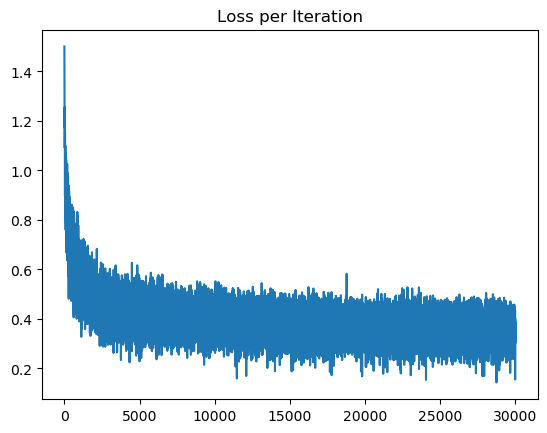

In [39]:
plt.plot(loss_i)
plt.title("Loss per Iteration");

<u>Biases:</u> At initialization we can set all bias vectors to 0. This makes sure that all neurons start in a neutral position. Note that we should only set the biases to 0 if we keep the weights randomized. This is because when everything is initialized at 0, then all neurons would learn the same behavior and be redundant (breaking symmetry).

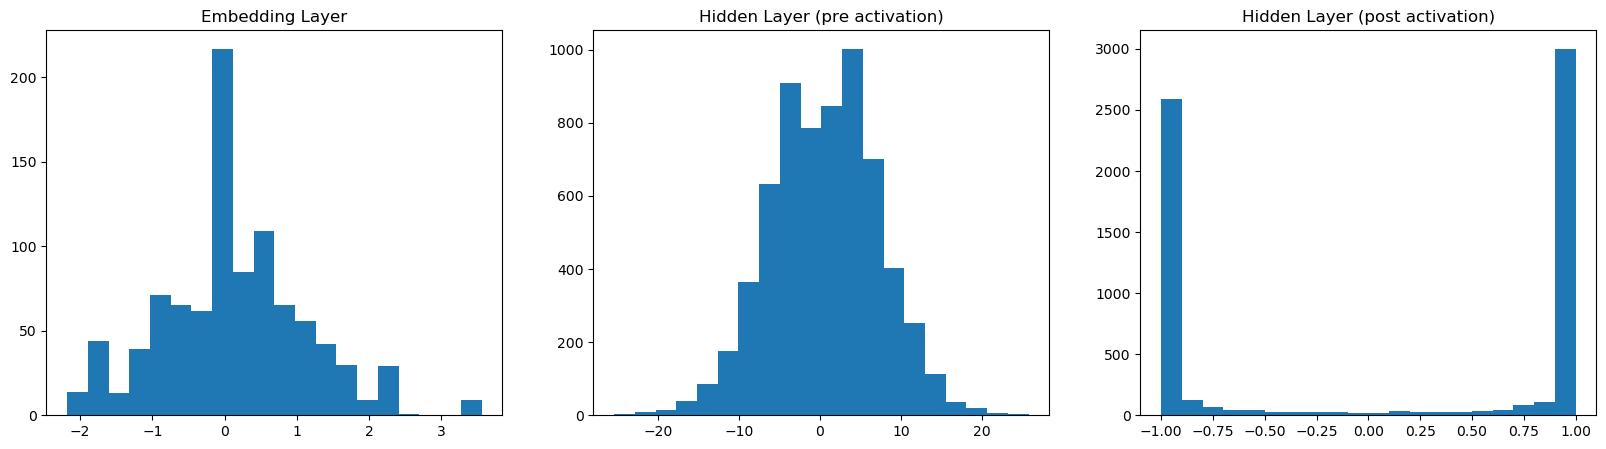

In [46]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))
ax[0].hist(embedd_layer.data.view(-1), bins=20)
ax[1].hist(hidden_preact.data.view(-1), bins=20)
ax[2].hist(hidden_layer.data.view(-1), bins=20)

ax[0].set_title("Embedding Layer")
ax[1].set_title("Hidden Layer (pre activation)")
ax[2].set_title("Hidden Layer (post activation)")

plt.show()

We also need to adjust <code>W1</code>. This is because the matrix multiplication before the activation function is still centered around 0, but the variance has increased. This leads to the activation function squeezing majority of observations to 1 or -1. At these flat regions of the activation function, there is bascially no gradient. This can lead to dead neurons with 0 gradients for every input.

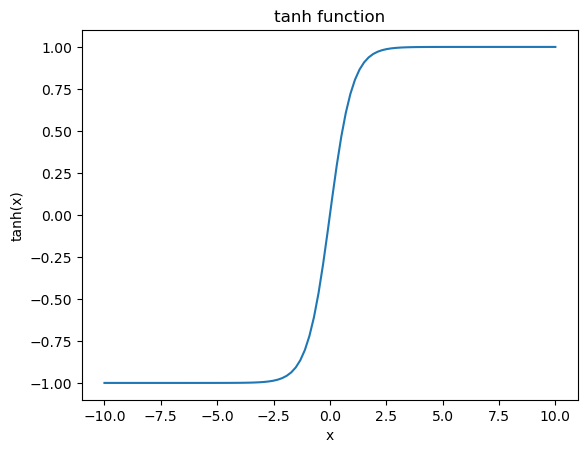

In [49]:
import numpy as np

x = np.linspace(-10, 10, 100)
y = np.tanh(x)

plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("tanh(x)")
plt.title("tanh function")
plt.show()

In [51]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer

g = torch.Generator().manual_seed(42)

# Weights an biases
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

params = [C, W1, b1, W2, b2]

for p in params:
    p.requires_grad = True

### Batch Normalization
***

When neural networks get deeper it gets intractible to scale the initializations properly. Therefore we can instead just normalize the inputs during the forward pass, before the activation function is applied. We simply standardize the pre activation by the batch mean and batch standard deviation. This results in several effects:
- By relying on the batch statistics, the observations within a batch are now mathematically connected. Before the forward pass of each training example was independent of the other. Predictions on new data rely on batch information.
- Relying on the batch statistics applies some sort of regularization, as it prevents overfitting on single examples.
- The pre-activtion is forced into a N(0,1). To give back flexibility, we need to add a shift <code>bn_gain</code> and a scaling parameter<code>bn_bias</code>.

In [85]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer

g = torch.Generator().manual_seed(42)

# Weights an biases
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
# b1 = torch.randn(n_hidden,                        generator=g) * 0
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# Batch norm parameters
bn_gain = torch.ones((1, n_hidden))
bn_bias = torch.zeros((1, n_hidden))
bn_mean_running = torch.zeros((1, n_hidden))
bn_std_running = torch.ones((1, n_hidden))

params = [C, W1, W2, b2, bn_gain, bn_bias]

for p in params:
    p.requires_grad = True


The <code>b1</code> parameter will not be relevant anymore as it is offset by the <code>bn_gain</code> parameter.

In [86]:
n_params = sum([p.nelement() for p in params])
n_params

12097

In [87]:
max_steps = 50_000
batch_size = 32
learn_rate = 0.1
loss_i = []

for i in range(max_steps):
    
    # Randomly draw indizes from X_train that go into minibatch
    idx = torch.randint(low=0, high=n1, size=(batch_size,))
    X_mini = X_train[idx]
    Y_mini = Y_train[idx]
    
    # Forward pass
    embedd_layer = C[X_mini]
    hidden_preact = embedd_layer.view(batch_size, -1) @ W1
    
    # Batch norm layer
    # -------------------------------------------------------------
    bn_mean_i = hidden_preact.mean(0, keepdim=True)
    bn_std_i = hidden_preact.std(0, keepdim=True)
    
    hidden_preact = bn_gain * (hidden_preact - bn_mean_i) / bn_std_i + bn_bias
    # Calculate the running average for prediction
    with torch.no_grad():
        bn_mean_running = 0.999 * bn_mean_running + 0.001 * bn_mean_i
        bn_std_running = 0.999 * bn_std_running + 0.001 * bn_std_i
    # -------------------------------------------------------------
    
    hidden_layer = torch.tanh(hidden_preact)
    output_layer = hidden_layer @ W2 + b2
    loss = F.cross_entropy(output_layer, Y_mini)
    
    # Backward pass
    for p in params:
        p.grad = None
    loss.backward()
    
    # Update gradient
    for p in params:
        p.data += learn_rate * -p.grad

    loss_i.append(loss.log10().item())
    if i % 10000 ==0:
        print("{:7d} / {:7d}: {:.4f}".format(i, max_steps, loss))

      0 /   50000: 3.3145
  10000 /   50000: 2.5037
  20000 /   50000: 1.9022
  30000 /   50000: 2.1255
  40000 /   50000: 2.2797


<u>Summary:</u> The normalization step in batch normalization makes the input to the activation function more consistent within each mini-batch, which helps in better learning of weights and biases. It reduces the internal covariate shift and provides a stable and consistent input distribution to subsequent layers.

Adding back the scaling and drifting parameters allows the preactivation of each neuron to have the flexibility to deviate from a standard Gaussian distribution. The scaling parameter, also known as the “scale parameter,” allows the network to learn the optimal scale for the normalized values. It can increase or decrease the magnitude of the normalized values, enabling the network to have different activation ranges for different layers or units.

In [91]:
# this decorator disables gradient tracking
@torch.no_grad()
def split_loss(split):
    x,y = {
        "train": (X_train, Y_train),
        "valid": (X_valid, Y_valid),
        "test": (X_test, Y_test),
    }[split]

    embedd_layer = C[x]
    n_obs = len(C[x])
    hidden_preact = embedd_layer.view(n_obs, -1) @ W1  
    hidden_preact = bn_gain * (hidden_preact - bn_mean_running) / bn_std_running + bn_bias 
    hidden_layer = torch.tanh(hidden_preact)
    output_layer = hidden_layer @ W2 + b2
    loss = F.cross_entropy(output_layer, y)
    print(loss)

In [94]:
split_loss("train")
split_loss("valid")

tensor(2.2956)
tensor(2.3464)


### Pytorch
***

In [9]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta # rescaled and shifted by trained parameters
        # update the buffers
        if self.training:
            with torch.no_grad():
               self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
               self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
  
    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []


In [25]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

47024


In [26]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
learn_rate = 0.1
lossi = []
ud = []

for i in range(max_steps):
  
    # Randomly draw indizes from X_train that go into minibatch
    idx = torch.randint(low=0, high=n1, size=(batch_size,), generator=g)
    X_mini = X_train[idx]
    Y_mini = Y_train[idx]

    # Forward pass
    embedd_layer = C[X_mini] # embed the characters into vectors
    x = embedd_layer.view(embedd_layer.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Y_mini) # loss function

    # Backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_grad
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update gradient
    for p in parameters:
        p.data += learn_rate * -p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((learn_rate*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.3064


layer 2 (      Tanh): mean -0.01, std 0.63, saturated: 3.75%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 3.19%
layer 8 (      Tanh): mean +0.01, std 0.64, saturated: 2.91%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 2.38%
layer 14 (      Tanh): mean +0.00, std 0.66, saturated: 2.28%


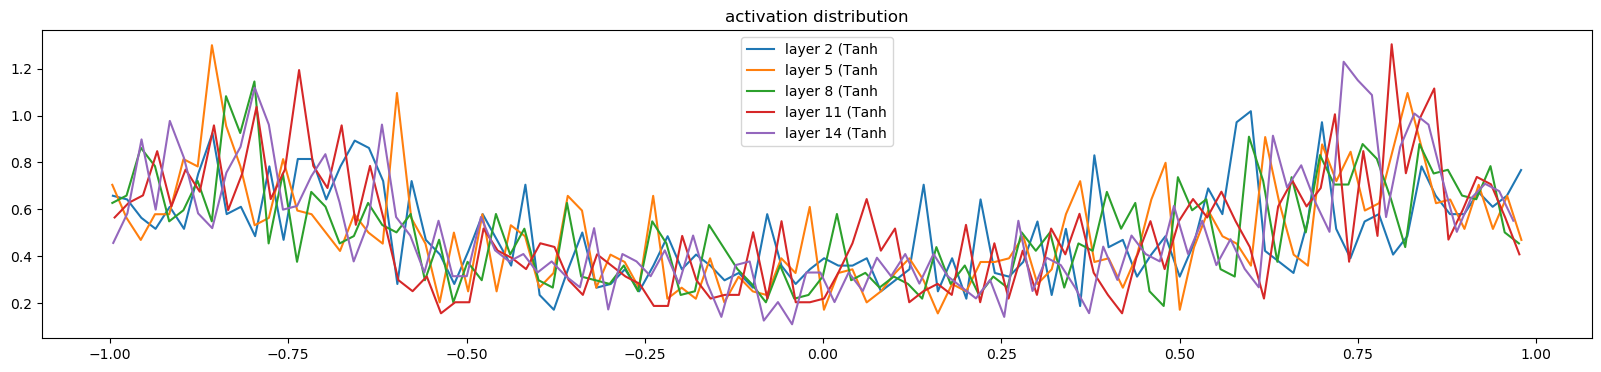

In [31]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution');

layer 2 (      Tanh): mean -0.000000, std 2.810923e-03
layer 5 (      Tanh): mean +0.000000, std 2.226306e-03
layer 8 (      Tanh): mean -0.000000, std 2.105585e-03
layer 11 (      Tanh): mean +0.000000, std 1.990785e-03
layer 14 (      Tanh): mean +0.000000, std 1.947325e-03


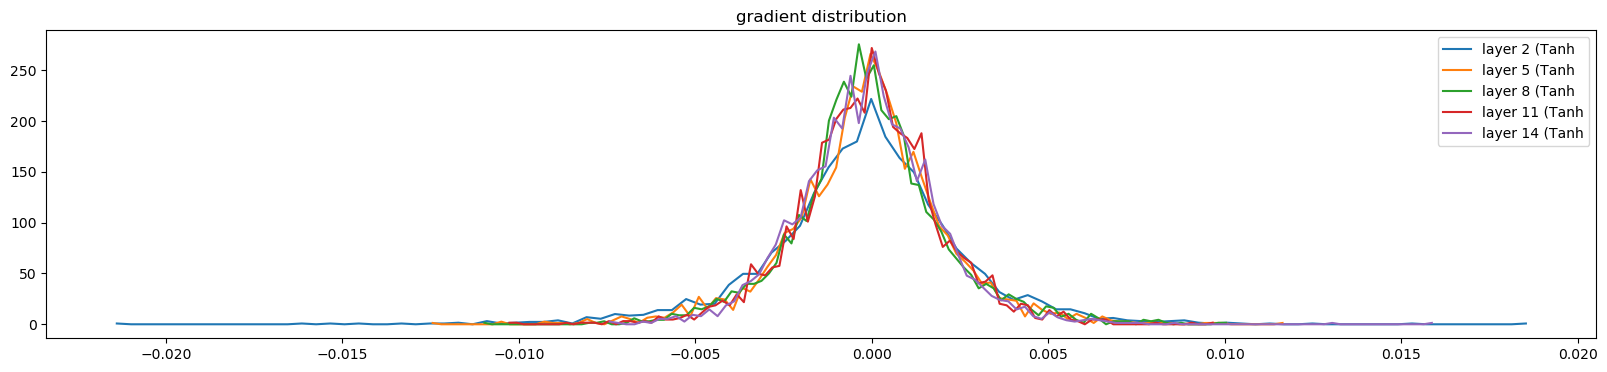

In [32]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution');

weight   (27, 10) | mean -0.000000 | std 1.007819e-02 | grad:data ratio 1.006324e-02
weight  (30, 100) | mean +0.000155 | std 1.014340e-02 | grad:data ratio 5.250698e-02
weight (100, 100) | mean +0.000061 | std 7.544023e-03 | grad:data ratio 7.117878e-02
weight (100, 100) | mean -0.000045 | std 6.702668e-03 | grad:data ratio 6.366557e-02
weight (100, 100) | mean +0.000056 | std 6.089884e-03 | grad:data ratio 5.844671e-02
weight (100, 100) | mean -0.000019 | std 5.982173e-03 | grad:data ratio 5.769809e-02
weight  (100, 27) | mean -0.000167 | std 1.146245e-02 | grad:data ratio 1.028175e-01


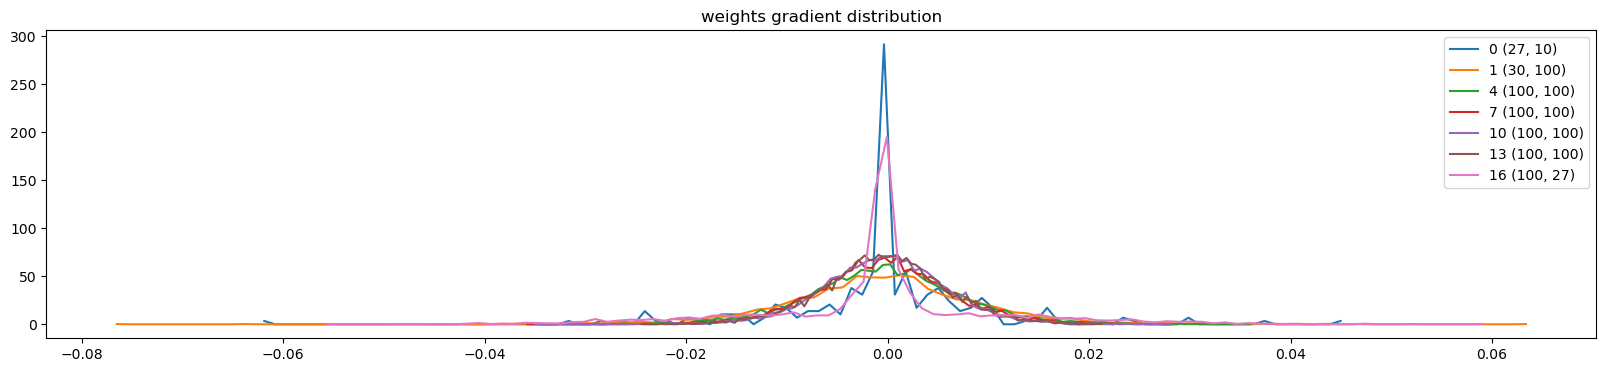

In [13]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

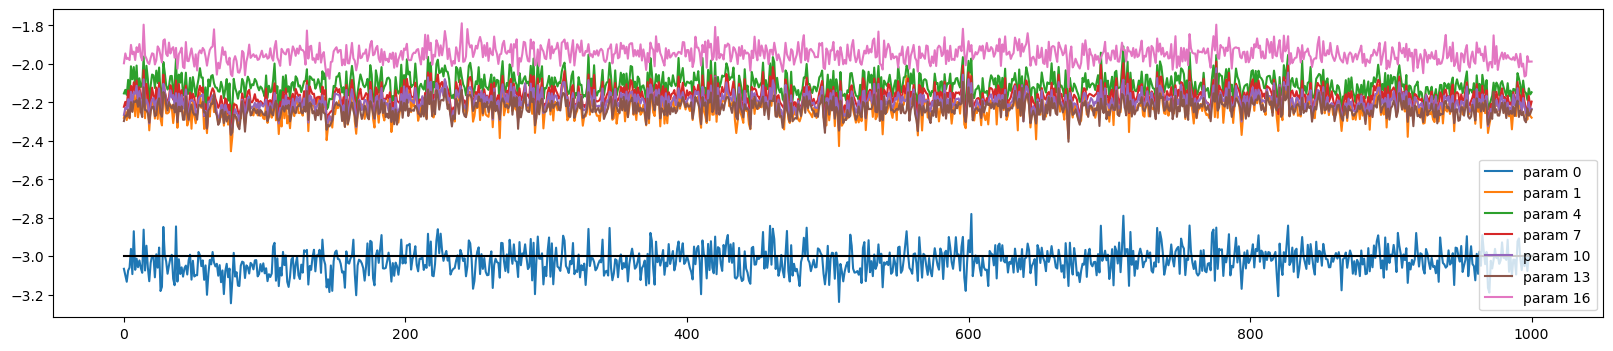

In [14]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);